In [1]:
import pandas as pd
pd.set_option('display.max_rows', 10000)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sys
import glob
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import savgol_filter
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import KFold
import torch.nn.functional as F
import torch.nn.init as init
import torch.nn.utils as torch_utils
import numpy as np
import pandas as pd
import re
from matplotlib import pyplot as plt
import torch
import gpytorch
import matplotlib.pyplot as plt
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import GridSearchCV
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np
import torch
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler


In [2]:
#%%

# %%
# INDOORS 1 SUN
file = pd.ExcelFile('Indoor MPP_ICN2_Nov. 2022_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')# the whole excel file 
sn = file.sheet_names # sheets that are the excel file 
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl') # read the data from the first sheet 

temperature = data_frame.loc[(data_frame["Parameter"]     =="Annealing temperature")].to_numpy() #take the temperature from the row Annealing temperature of column Parameters and convert it to numpy
temperature = temperature[2,2:] # take everything from temperature starting from the third row and the third column
 
devices = data_frame.columns.to_numpy() # take the devices from the data and convert them to numpy
 
devices = np.reshape(devices, (devices.shape[0],1)) 
devices = devices[2:] #excluding the first two elements

time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl') # read the data from the last sheet

time_series_df = time_series_df.drop(index =[0]) # drop the first row (einheiten)
time = time_series_df.iloc[:,0] # take the time from the first column
 
# print(time)
time_series_1_sun = []
for i in range (temperature.shape[0]):
    time_series_1_sun.append(time_series_df.iloc[:,2+i*3]) ### for every device take the impp (optimal current output that the solar panel can generate when it is operating at its maximum power point)

time_series_1_sun = np.array(time_series_1_sun) # convert it to array [shape(24, 4001)]

# %% 
# 1.4 SUN

file = pd.ExcelFile('Indoor MPP_1.4 sun_ICN2_Feb. 2023_Tripple cat.-Variable Annealing temps.xlsx', engine='openpyxl')
sn = file.sheet_names
data_frame = pd.read_excel(file,sn[0],  engine='openpyxl')

# temperature
devices = data_frame.columns.to_numpy()
devices = np.reshape(devices, (devices.shape[0],1))
devices = devices[2:]
time_series_df = pd.read_excel(file,sn[-1],  engine='openpyxl')
time_series_df = time_series_df.drop(index =[0])
time = time_series_df.iloc[:,0]

# print(time)
time_series_1_4_sun = []
for i in range (temperature.shape[0]):
    time_series_1_4_sun.append(time_series_df.iloc[:,2+i*3])
time_series_1_4_sun = np.array(time_series_1_4_sun)#[shape(24, 1313)]

# %%

# %%
# OUTDOOR CONDITIONS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_conditions = pd.read_csv('outdoor_conditions_unnormalized.txt', sep='\t')

irradiance = outdoor_conditions['irradiance'] #[shape(4794,)]
rh = outdoor_conditions['rh'] #[shape(4794,)]
 
outdoor_temperature = outdoor_conditions['outdoor_temperature'] #[shape(4794,)]

outdoor_condition_time = outdoor_conditions['time'] #[shape(4794,)] 
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
outdoor_temperature = outdoor_temperature.fillna(outdoor_temperature.mean())
irradiance = irradiance.fillna(irradiance.mean())
rh = rh.fillna(rh.mean())
scaler = MinMaxScaler()
 
# Normalize irradiance column
irradiance_normalized = scaler.fit_transform(outdoor_conditions['irradiance'].values.reshape(-1, 1))

# Normalize rh column
rh_normalized = scaler.fit_transform(outdoor_conditions['rh'].values.reshape(-1, 1))

# Normalize outdoor_temperature column
outdoor_temperature_normalized = scaler.fit_transform(outdoor_conditions['outdoor_temperature'].values.reshape(-1, 1))

# Create a new DataFrame with normalized columns
outdoor_conditions_normalized = pd.DataFrame({
    'irradiance_normalized': irradiance_normalized.flatten(),
    'rh_normalized': rh_normalized.flatten(),
    'outdoor_temperature_normalized': outdoor_temperature_normalized.flatten(),
    'time': outdoor_conditions['time']
})

# Save the normalized DataFrame to a new file
outdoor_conditions_normalized.to_csv('outdoor_conditions_normalized.txt', sep='\t')
outdoor_conditions_normalized=pd.read_csv('outdoor_conditions_normalized.txt', sep='\t')
# %%
# OUTDOOR PANELS
# file = pd.read_csv('outdoor_conditions.txt')
outdoor_panels = pd.read_csv('outdoor_data_imputed.txt', sep ='\t')
# outdoor_panels.head()
outdoor_panels_power = [] 
for i in range(temperature.shape[0]):
    outdoor_panels_power.append(outdoor_panels[str(i)])
outdoor_panels_power = np.array(outdoor_panels_power) #[shape(24, 4794)]

#%%
# Padding


time_series_1_sun_shape = time_series_1_sun.shape
time_series_1_4_sun_shape = time_series_1_4_sun.shape
time_series_1_sun = np.pad(time_series_1_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_sun.shape[1])),mode='edge')    
time_series_1_4_sun = np.pad(time_series_1_4_sun, ((0,0),(0,outdoor_panels_power.shape[1] - time_series_1_4_sun.shape[1])),mode='edge' )    
time_series_1_sun = np.reshape(time_series_1_sun, ((time_series_1_sun.shape[0],time_series_1_sun.shape[1],1)))
time_series_1_4_sun = np.reshape(time_series_1_4_sun, ((time_series_1_4_sun.shape[0],time_series_1_4_sun.shape[1],1)))
outdoor_panels_power = np.reshape(outdoor_panels_power, ((outdoor_panels_power.shape[0],outdoor_panels_power.shape[1],1)))

In [3]:
# Calculate average values for time_series_1_sun
time_series_1_sun_average = np.zeros((12, 4794, 1))
j = 0
for i in range(time_series_1_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_sun_average[j] = np.mean(time_series_1_sun[i-1:i+1], axis=0)
        j += 1
 
     

# Calculate average values for time_series_1_4_sun
time_series_1_4_sun_average = np.zeros((12, 4794, 1))
k = 0
for i in range(time_series_1_4_sun.shape[0]):
    if (i+1) % 2 == 0:
        time_series_1_4_sun_average[k] = np.mean(time_series_1_4_sun[i-1:i+1], axis=0)
        k += 1

# Calculate average values for outdoor_panels_power
outdoor_panels_power_average = np.zeros((12, 4794, 1))
b = 0
for i in range(outdoor_panels_power.shape[0]):
    if (i+1) % 2 == 0:
        outdoor_panels_power_average[b] = np.mean(outdoor_panels_power[i-1:i+1], axis=0)
        outdoor_panels_power_average[b][outdoor_panels_power_average[b] < 0] = 0 # Set negative values to 0
        b += 1

# Stack the outdoor conditions
outdoor_conditions_stacked = np.stack([outdoor_conditions ] * 12, axis=0)
outdoor_conditions_stacked_2= np.stack([outdoor_conditions] * 20, axis=0)

In [4]:
def exponential_smoothing(series, alpha):
    smoothed_series = [series[0]]  # Initialize the smoothed series with the first value of the original series
    for i in range(1, len(series)):
        smoothed_value = alpha * series[i] + (1 - alpha) * smoothed_series[-1]
        smoothed_series.append(smoothed_value)
    return np.array(smoothed_series)
 
alpha = 0.1   
for i in range (time_series_1_sun_average.shape[0]):
 
  time_series_1_sun_average[i] = exponential_smoothing(time_series_1_sun_average[i], 0.1)
  outdoor_panels_power_average[i] = exponential_smoothing(outdoor_panels_power_average[i], 0.7)

In [5]:
all_new_features = np.concatenate((time_series_1_sun_average ,outdoor_conditions_stacked), axis=2)# concatenate the input for the model
print(all_new_features.shape)
print(outdoor_panels_power_average.shape)

(12, 4794, 6)
(12, 4794, 1)


In [6]:
import numpy as np
import torch
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C,RationalQuadratic,ExpSineSquared,DotProduct
from sklearn.multioutput import MultiOutputRegressor
from sklearn.decomposition import KernelPCA
from sklearn.preprocessing import StandardScaler,MaxAbsScaler
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.covariance import EllipticEnvelope
 
from sklearn.metrics import mean_squared_error

# Specify the number of samples
num_samples =all_new_features.shape[0]

# Reshape the data to have the shape (num_samples, num_features)
all_new_features_reshaped = all_new_features.reshape(num_samples, -1)
outdoor_panels_power_average_reshaped = outdoor_panels_power_average.reshape(num_samples, -1)




# Define the number of folds for cross-validation
num_folds = 12

# Initialize lists to store the average MSE for each fold
average_mse_scores1 = []
average_mse_scores2 = []
fold = 0
y_pred1=np.zeros(( 1, 4794))
y_pred2=np.zeros(( 1, 4794))
# Initialize arrays to store the predictions and test data for each fold
predictions1 = np.zeros((12, 1, 4794))
test1= np.zeros((12, 1, 4794))
predictions2 = np.zeros((12, 1, 4794))
test2 = np.zeros((12, 1, 4794))
# Perform k-fold cross-validation
 

for temp in range(6):
    test_index=[2*temp,2*temp+1]
    train_index = [i for i in range(num_samples) if i not in test_index]
    print(test_index)
    print(train_index )
 
    X_train, X_test = all_new_features_reshaped [train_index], all_new_features_reshaped [test_index]
    y_train, y_test = outdoor_panels_power_average_reshaped[train_index], outdoor_panels_power_average_reshaped[test_index]
    scaler = MaxAbsScaler()
    X_train= scaler.fit_transform(X_train)
    X_test= scaler.transform(X_test)
    print(X_test.shape)
    xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=10, max_depth=3, learning_rate=0.1,
                                 reg_alpha=0.1, reg_lambda=0.1)
    xgb_model.fit(X_train, y_train)
    y_pred1 =xgb_model.predict(X_test[0].reshape(1, -1))
    y_pred2 =xgb_model.predict(X_test[1].reshape(1, -1))
    predictions1[fold] = y_pred1
    predictions2[fold] = y_pred2
    test1[fold] = y_test[0]
    test2[fold] = y_test[1]
    error1 = mean_squared_error(y_test[0].reshape(1, -1), y_pred1)
    error2= mean_squared_error(y_test[1].reshape(1, -1), y_pred2)
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error1))
    print("Fold {} - Mean Squared Error: {}".format(fold + 1, error2))

    average_mse_scores1.append(error1)
    average_mse_scores2.append(error2)
    fold = fold + 1
    if fold == 6:
        break

# Calculate the average MSE across all folds
average_mse1 = np.mean(average_mse_scores1)
average_mse2 = np.mean(average_mse_scores2)
print(f"Average Mean Squared Error: {average_mse1}")
print(f"Average Mean Squared Error: {average_mse2}")

[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
(2, 28764)
Fold 1 - Mean Squared Error: 0.7414831216979056
Fold 1 - Mean Squared Error: 0.4134955261196798
[2, 3]
[0, 1, 4, 5, 6, 7, 8, 9, 10, 11]
(2, 28764)
Fold 2 - Mean Squared Error: 1.7058970622033214
Fold 2 - Mean Squared Error: 4.61475813337665
[4, 5]
[0, 1, 2, 3, 6, 7, 8, 9, 10, 11]
(2, 28764)
Fold 3 - Mean Squared Error: 1.958202701558182
Fold 3 - Mean Squared Error: 0.4626197843364534
[6, 7]
[0, 1, 2, 3, 4, 5, 8, 9, 10, 11]
(2, 28764)
Fold 4 - Mean Squared Error: 0.45900809977111506
Fold 4 - Mean Squared Error: 0.44163495329676467
[8, 9]
[0, 1, 2, 3, 4, 5, 6, 7, 10, 11]
(2, 28764)
Fold 5 - Mean Squared Error: 0.528223318803425
Fold 5 - Mean Squared Error: 1.2683959300755914
[10, 11]
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
(2, 28764)
Fold 6 - Mean Squared Error: 3.100691982256884
Fold 6 - Mean Squared Error: 0.5856672872959092
Average Mean Squared Error: 1.415584381048472
Average Mean Squared Error: 1.2977619357501748


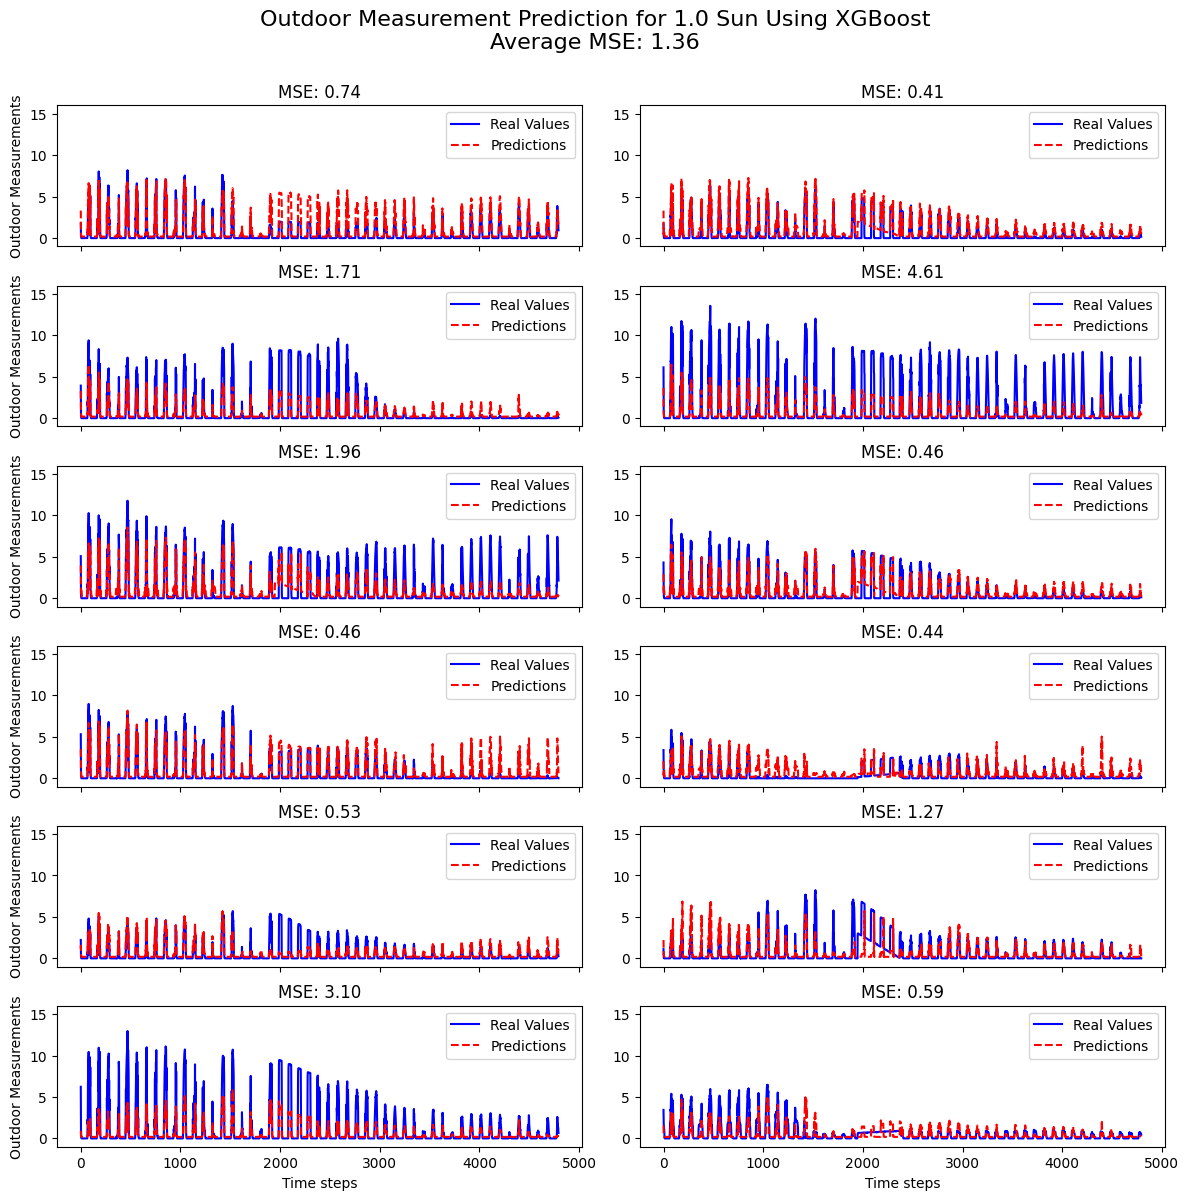

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(6, 2, figsize=(12, 12), sharex=True)


for fold in range(6):
  
    y_pred_fold1 = predictions1[fold].squeeze()  
    y_pred_fold2 = predictions2[fold].squeeze()
    y_test_fold1 = test1[fold].squeeze()
    y_test_fold2 = test2[fold].squeeze()

    axes[fold, 0].plot(y_test_fold1, label='Real Values', color='blue')
    axes[fold, 0].plot(y_pred_fold1, label='Predictions', color='red',linestyle='dashed')
    axes[fold, 0].set_ylabel('Outdoor Measurements')
     
    axes[fold, 0].set_title(f'MSE: {average_mse_scores1[fold]:.2f}')
    axes[fold, 0].legend()
    axes[fold, 0].set_ylim(-1, 16)
   
    axes[fold, 1].plot(y_test_fold2, label='Real Values', color='blue')
    axes[fold, 1].plot(y_pred_fold2, label='Predictions', color='red',linestyle='dashed')
     
    axes[fold, 1].set_title(f'MSE: {average_mse_scores2[fold]:.2f}') 
    axes[fold, 1].legend()
    axes[fold, 1].set_ylim(-1, 16)

plt.tight_layout()
average_mse_all = (average_mse1+average_mse2)/2
axes[-1, 0].set_xlabel('Time steps')
axes[-1, 1].set_xlabel('Time steps')
fig.suptitle(f'Outdoor Measurement Prediction for 1.0 Sun Using XGBoost\nAverage MSE: {average_mse_all:.2f}', fontsize=16)
fig.subplots_adjust(top=0.9)
plt.savefig('1.0 sun using GP.pdf')
plt.show()